# Data Analytics 111-2 Homework #02

In [13]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

## a. Read the 400 images into one data matrix 400 × 2576. Create an additional label column indicating the physical gender, e.g., {0 = female, 1 = male}.

In [14]:
# Create an empty NumPy array to store the images and a gender column
#400 rows one for each picture, 2576 columns for the image, 1 for the gender
data_matrix = np.zeros((400, 2577))

# Get a list of all PNG files in the directory
files = glob.glob("ORL Faces/*.png")

# Loop through the image files and read them into the data matrix
for i, filename in enumerate(files):
    # Read the image using OpenCV
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    # Resize the image to 46x56
    img = cv2.resize(img, (56, 46))
    
    # Flatten the image into a 1D array and store it in the data matrix
    data_matrix[i, :-1] = img.flatten()
    
    # Check the filename to determine gender
    if filename.split("/")[-1].startswith(("1_", "8_", "10_", "32_")):
        data_matrix[i, -1] = 0
    else:
        data_matrix[i, -1] = 1

# Print the shape of the data matrix
print(data_matrix.shape)


(400, 2577)


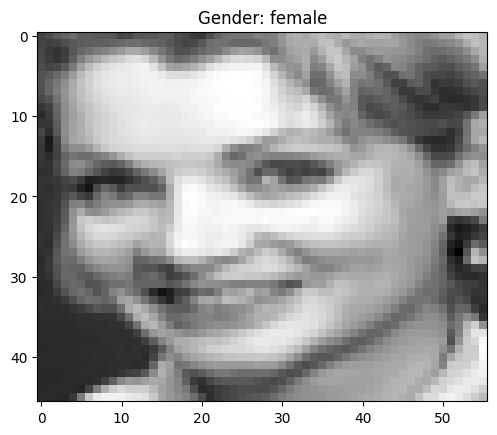

In [15]:
img = data_matrix[0, :-1].reshape((46, 56))  # Reshape the flattened image to its original dimensions
gender = "female" if data_matrix[0, -1] == 0 else "male"  # Get the gender label for the image

# Print the image using Matplotlib
plt.imshow(img, cmap="gray")
plt.title(f"Gender: {gender}")
plt.show()

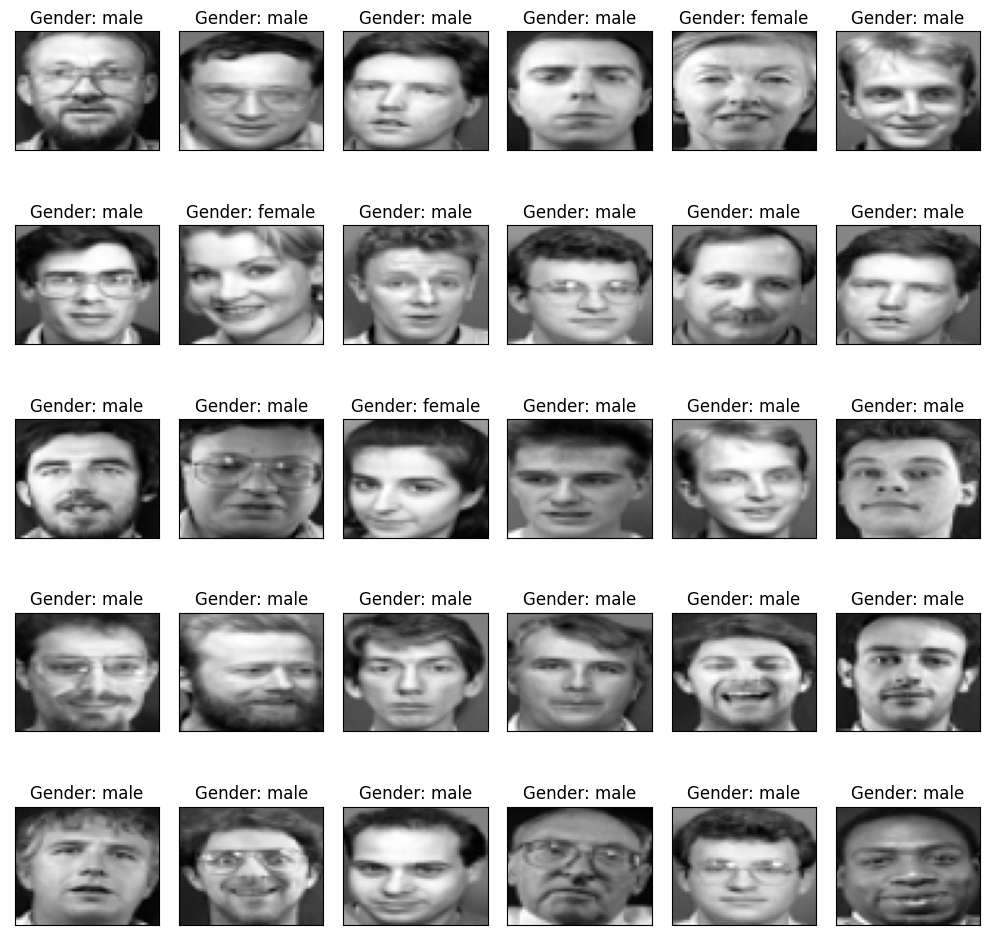

In [16]:
import random

# Set the figure size
plt.figure(figsize=(10, 10))

# Generate 30 random image indices
random_indices = random.sample(range(400), 30)

# Loop through the random image indices and print each image
for i, index in enumerate(random_indices):
    # Get the image and gender label
    img = data_matrix[index, :-1].reshape((46, 56))
    gender = "female" if data_matrix[index, -1] == 0 else "male"
    
    # Create a subplot for the image
    plt.subplot(5, 6, i+1)
    
    # Print the image
    plt.imshow(img, cmap="gray")
    plt.title(f"Gender: {gender}")
    
    # Remove the axis ticks
    plt.xticks([])
    plt.yticks([])

# Adjust the subplot spacing
plt.tight_layout()

# Show the plot
plt.show()


## b. 1. Regress the gender label on all the 2576 pixels? What do you observe?

In [17]:
# Load the data matrix and label column
img_data = data_matrix[:,:-1]
label_column = data_matrix[:, 2576]

# Train a linear regression model on the data
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(img_data, label_column)

# Print the coefficients of the linear regression model
print("Regression coefficients:", model.coef_)

Regression coefficients: [ 7.64300761e-05  9.77767820e-05  1.17934077e-04 ... -1.78755060e-04
 -3.33781423e-04 -2.38867829e-04]


In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Predict the labels for the input data using the trained model
predicted_labels = model.predict(img_data)

# Calculate the R^2 score
r2 = r2_score(label_column, predicted_labels)

# Calculate the mean squared error
mse = mean_squared_error(label_column, predicted_labels)

# Calculate the mean absolute error
mae = mean_absolute_error(label_column, predicted_labels)

# Print the evaluation metrics
print("R^2 score:", r2)
print("Mean squared error:", mse)
print("Mean absolute error:", mae)

R^2 score: 1.0
Mean squared error: 1.3932331292092815e-30
Mean absolute error: 9.223177777073487e-16


## Conclusion
Based on these above values (R^2 score, MSE and MAE) we can determine that the model does quite well on the given task. A R^2 scor of 1 means that the model can explain all  of the variance in the target variable, the very small MSE and MAE also indicates that the model is making highly accurate predictions with very little error

## b) 2. Perform the stepwise regression from a null model to find the important pixels. Plot the chosen pixels on a 46 × 56 canvas.

10 most significant pixels

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Define the stepwise regression object, which will use a linear regression model and select 10 features
sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=10, direction='forward')

# Fit the stepwise regression object to the input data and select the most important pixels
sfs.fit(img_data, label_column)
significant_pixels = sfs.get_support(indices=True)

# Plot:
# Create a blank 46 x 56 canvas
canvas = np.zeros((46, 56))

# Set the chosen significant pixels to 1 on the canvas
for pixel in significant_pixels:
    x, y = divmod(pixel, 56)
    canvas[x, y] = 1

# Display the canvas with the chosen significant pixels
plt.imshow(canvas, cmap='gray')
plt.show()

# 2. The volcano dataset


We can simply assign the grid coordinates as: 𝑥1 = {1, 2, … , 87}; 𝑥2 = {1, 2, … ,61}.
Design an iterative algorithm based on repeating “multiple regressions” to arrive the highest point of this
volcano, given the starting point at (87, 1), i.e., the right-bottom corner.
Hint: you can consider a smaller domain of 𝑥1 and 𝑥2 to build a regression model, such that the linear
hyperplane can show you an improving direction to another domain.

In [ ]:
# Load volcano.csv to df and set column labels and index
df_volcano = pd.read_csv('Volcano.csv', header=None)
df_volcano.columns = range(1, 88)  # set column labels to 1..87
df_volcano.index = range(1, 62)   # set index labels to 1..61

df_volcano

In [22]:
# Define the regression model
def regression_model(x1, x2, y):
    X = np.column_stack((np.ones_like(x1.flatten()), x1.flatten(), x2.flatten()))
    w = np.linalg.lstsq(X, y.flatten(), rcond=None)[0]
    return w

# Set the starting point
x1, x2 = 87, 1

# Define the window size and maximum number of iterations
window_size = 10
max_iterations = 1000

# Loop until the maximum number of iterations is reached or the highest point is found
iteration = 0
while iteration < max_iterations:
    # Define the window around the current point
    x1_window = df_volcano.columns[(df_volcano.columns >= x1-window_size) & (df_volcano.columns <= x1+window_size)]
    x2_window = df_volcano.index[(df_volcano.index >= x2-window_size) & (df_volcano.index <= x2+window_size)]
    df_window = df_volcano.loc[x2_window, x1_window]
    
    # Reshape the data into arrays
    x1, x2 = np.meshgrid(df_window.columns, df_window.index)
    y = df_window.values.reshape(-1, 1)
    
    # Fit the regression model and predict the values
    w = regression_model(x1, x2, y)
    y_pred = w[0] + w[1]*x1 + w[2]*x2
    
    # Find the next point with the highest predicted value
    index = np.argmax(y_pred)
    x1, x2 = x1.flatten()[index], x2.flatten()[index]
    
    # Increment the iteration counter
    iteration += 1

# Print the coordinates of the highest point
print(f"The highest point is at ({x1}, {x2})")

The highest point is at (27, 41)


In [23]:
df_volcano[x1][x2]

175

The code is implementing a gradient ascent algorithm to find the maximum value of a function defined by two variables, x1 and x2. The algorithm starts with an initial point (x1, x2) and iteratively moves to a higher point on the function surface by taking small steps in the direction of steepest ascent (i.e., the direction of the gradient).

The dataset has three columns: x1, x2, and y, where y is the value of the function at each point (x1, x2). The regression model used to fit the dataset is a linear model of the form y = w0 + w1x1 + w2x2, where w0, w1, and w2 are the regression coefficients.

The algorithm works as follows:

    1. Load the dataset 
    2. Set the starting point
    3. Define a window around the current point by selecting all data points within 10 units of x1 and x2.
    4. Fit a regression model to the data within the window.
    5. Use the regression model to predict the value of the function at all points in the dataset.
    6. Move to the point with the highest predicted value.
    7. Repeat steps 3-6 until the maximum number of iterations is reached or the highest point is found.

## Conclusion
It seems like my algorithm got stuck in a local maxima and did not manage to find the global maxima

# 3 Simulate a “multiple” regression with two predictors problem by yourself, with sufficient sample size, e.g., 50000 samples.
𝑦 = 𝛽0 + 𝛽1𝑥1 + 𝛽2𝑥2 + 𝜖, 𝜖~𝑁(0, 𝜎2).
*Make any necessary assumptions by yourself if not mentioned above.

## a. (5%) Use the regression package in your preferable environment (R or Python) to analyze the problem and review the results.

In [10]:
!pip install statsmodels
import statsmodels.api as sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 25.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 11.8 MB/s eta 0:00:00


In [11]:
# Set the seed for reproducibility
np.random.seed(123)

# Define the true coefficients
beta0 = 5
beta1 = 2
beta2 = 3

# Define the standard deviation of the error term
sigma = 2

# Generate the predictor variables x1 and x2
x1 = np.random.normal(0, 1, size=50000)
x2 = np.random.normal(0, 1, size=50000)

# Generate the error term
epsilon = np.random.normal(0, sigma, size=50000)

# Generate the response variable y
y = beta0 + beta1*x1 + beta2*x2 + epsilon

# Combine the predictor and response variables into a dataframe
data = pd.DataFrame({'y': y, 'x1': x1, 'x2': x2})

# Fit a multiple regression model with two predictors
model = sm.formula.ols('y ~ x1 + x2', data=data).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                 8.259e+04
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:23:15   Log-Likelihood:            -1.0540e+05
No. Observations:               50000   AIC:                         2.108e+05
Df Residuals:                   49997   BIC:                         2.108e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0029      0.009    561.617      0.0

The R-squared value of 0.768 indicates that the model explains 76.8% of the variance. The F-statistic is 8.259e+04 and its associated p-value is very small, indicating that the overall model is statistically significant.

The coefficients of the predictors x1 and x2 are estimated to be 2.0002 and 3.0043 respectively, with standard errors of 0.009. The intercept term is estimated to be 5.0029. Which is very close to the actuall values (beta0 = 5, beta1 = 2 and beta2 = 3). This indicates that the model has done a good job in capturing the relationship between the predictors and the response variable.

The standard errors of the coefficients are also small, which means that the estimates are precise. The small p-values for all three coefficients indicate that they are statistically significant predictors of the response variable.

Overall, the regression analysis suggests that the model is a good fit for the data and that the predictors have a significant impact on the response variable.

## b. (15%) From the perspective of “machine learning,” code the gradient descent method to optimize (minimize) the error function and get the coefficients.

In [12]:
# Generate random data
np.random.seed(0)
n = 50000
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 1, n)
epsilon = np.random.normal(0, 0.5, n)
y = 5 + 2 * x1 + 3 * x2 + epsilon

# Initialize coefficients and learning rate
beta0 = 5
beta1 = 2
beta2 = 3
learning_rate = 0.001
epochs = 1000

# Gradient descent
for i in range(epochs):
    # Calculate predicted values
    y_pred = beta0 + beta1 * x1 + beta2 * x2
    
    # Calculate errors
    errors = y_pred - y
    
    # Calculate partial derivatives of MSE w.r.t. beta0, beta1, and beta2
    d_beta0 = np.mean(errors)
    d_beta1 = np.mean(errors * x1)
    d_beta2 = np.mean(errors * x2)
    
    # Update values
    beta0 = beta0 - learning_rate * d_beta0
    beta1 = beta1 - learning_rate * d_beta1
    beta2 = beta2 - learning_rate * d_beta2

# Print the values
print("beta0:", beta0)
print("beta1:", beta1)
print("beta2:", beta2)

beta0: 5.003386755649797
beta1: 1.9981927446184857
beta2: 3.001288725620269


### Analysis
**Do you get the same results as those in (a)?**

a) 

Intercept      5.0029

x1             2.0002  
   
x2             3.0043
   
b) 
Intercept 5.003386755649797

x1: 1.9981927446184857

x2: 3.001288725620269

The results are very similar, but the results in a) are a little more accurate 